# US Housing Market Analysis

In [1]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
from bokeh.io import export_png
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Loading and cleaning data
We will be using data from [FRED](https://fred.stlouisfed.org/), the Federal Reserve Economic Data, and [AlphaVantage](https://www.alphavantage.co/), a free API for stock market data. The data collected from AlphaVantage is mostly commodity prices, and the data from FRED is mostly economic indicators. 

In [2]:
# Read in data
file_path = Path("data/housing_data3.csv")
df = pd.read_csv(file_path)
df.head()

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
0,1987-01-01,63.734,6.0,1690.0,90.4,1090.0,1774.0,108.1,58585,125.90971,1862.0,97900.0,18.65,111.2,6.43,384.227143,-0.506
1,1987-02-01,64.134,6.2,1689.0,90.2,1096.0,1784.0,109.4,53102,124.24761,1771.0,97900.0,17.75,111.6,6.10,411.712632,-0.495
2,1987-03-01,64.469,6.0,1704.0,90.8,1084.0,1726.0,110.6,43500,123.59781,1694.0,97900.0,18.30,112.1,6.13,432.204545,-0.335
3,1987-04-01,64.973,6.0,1601.0,92.8,1079.0,1614.0,110.7,54405,134.50752,1735.0,103400.0,18.68,112.7,6.37,422.771429,0.105
4,1987-05-01,65.547,6.7,1500.0,91.1,1070.0,1628.0,110.7,65151,144.95212,1713.0,103400.0,19.44,113.1,6.85,416.634000,0.540


In [3]:
df.tail()

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
428,2022-09-01,300.451,9.7,1588.0,58.6,1698.0,1463.0,322.849,72386,83.61149,1438.0,468000.0,84.26,296.81,2.56,11402.850000,-0.1320
429,2022-10-01,298.672,9.7,1555.0,59.9,1710.0,1432.0,317.617,65599,94.39124,1348.0,479500.0,87.55,298.01,3.08,10801.494286,-0.0925
430,2022-11-01,296.809,9.4,1402.0,56.8,1695.0,1427.0,312.864,55272,93.09166,1543.0,479500.0,84.37,297.71,3.78,10973.638095,-0.1725
431,2022-12-01,294.266,8.5,1409.0,59.7,1696.0,1357.0,308.076,47749,87.05882,1390.0,479500.0,76.44,296.80,4.10,10838.995714,-0.1960
432,2023-01-01,292.444,8.1,1354.0,64.9,1695.0,1340.0,306.461,40292,85.80711,1377.0,436800.0,78.12,299.17,4.33,11013.991000,-0.2825


In [4]:
# add a column 'Price Index 6 Months Later' to the dataframe and populate it with the price index 6 months later
df2 = df.copy()
df2['Price Index 6 Months Later'] = df2['Price Index'].shift(-6)
df2.tail(7)

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI,Price Index 6 Months Later
426,2022-07-01,307.135,10.1,1658.0,51.5,1683.0,1371.0,331.669,85499,74.04241,1396.0,468000.0,101.62,296.28,1.68,11622.631500,-0.1660,292.444
427,2022-08-01,303.649,8.7,1586.0,58.2,1702.0,1505.0,329.173,81651,71.44323,1355.0,468000.0,93.67,296.17,2.33,12570.260435,-0.2275,NaN
428,2022-09-01,300.451,9.7,1588.0,58.6,1698.0,1463.0,322.849,72386,83.61149,1438.0,468000.0,84.26,296.81,2.56,11402.850000,-0.1320,NaN
429,2022-10-01,298.672,9.7,1555.0,59.9,1710.0,1432.0,317.617,65599,94.39124,1348.0,479500.0,87.55,298.01,3.08,10801.494286,-0.0925,NaN
430,2022-11-01,296.809,9.4,1402.0,56.8,1695.0,1427.0,312.864,55272,93.09166,1543.0,479500.0,84.37,297.71,3.78,10973.638095,-0.1725,NaN
431,2022-12-01,294.266,8.5,1409.0,59.7,1696.0,1357.0,308.076,47749,87.05882,1390.0,479500.0,76.44,296.80,4.10,10838.995714,-0.1960,NaN
432,2023-01-01,292.444,8.1,1354.0,64.9,1695.0,1340.0,306.461,40292,85.80711,1377.0,436800.0,78.12,299.17,4.33,11013.991000,-0.2825,NaN


# Defining the feature and target variables

In [30]:
# Define features set
X = df2.copy()
X = X.drop("Date", axis=1)
X = X.drop("Price Index 6 Months Later", axis=1)
# drop last 6 rows
X = X[:-6]
X.tail(7)

,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
420,282.039,5.8,1898.0,67.2,1553.0,1669.0,349.222,73069,47.12722,1256.0,433100.0,83.22,281.15,0.08,14531.377500,-0.5425
421,287.284,6.2,1817.0,62.8,1581.0,1771.0,359.934,64039,51.47059,1371.0,433100.0,91.64,283.72,0.08,13898.727895,-0.4700
422,295.123,7.0,1877.0,59.4,1631.0,1713.0,372.864,64647,57.07250,1356.0,433100.0,108.50,287.50,0.20,13623.263043,-0.3675
423,301.789,8.5,1795.0,65.2,1669.0,1803.0,356.444,73334,68.16005,1361.0,449300.0,101.78,289.11,0.33,13394.163000,-0.3320
424,306.569,8.3,1708.0,58.4,1680.0,1543.0,358.834,83758,71.54583,1446.0,449300.0,109.55,292.30,0.77,11829.729524,-0.2525
425,308.334,9.5,1701.0,50.0,1688.0,1561.0,334.275,87679,75.54036,1392.0,449300.0,114.84,296.31,1.21,11418.919048,-0.1725
426,307.135,10.1,1658.0,51.5,1683.0,1371.0,331.669,85499,74.04241,1396.0,468000.0,101.62,296.28,1.68,11622.631500,-0.1660


In [31]:
# checking the shape of X and if there are any null values
print(X.shape)
print(X.isnull().sum())

(427, 16)
Price Index           0
Monthly Supply        0
Permits               0
Sentiment Index       0
Construction          0
Housing Starts        0
Lumber Price Index    0
Pair Count            0
Mortgage Rate         0
Units Completed       0
Sales Price           0
Oil Price             0
CPI                   0
Fed Funds Rate        0
NASDAQ                0
NFCI                  0
dtype: int64


# Creating the target vector 
Price Index = S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted)

In [32]:
# Define target vector 'Price Change' as y
y = df2["Price Index 6 Months Later"].values.reshape(-1, 1)
y = y[:-6]
y.shape

(427, 1)

# Splitting the data into training and testing sets

In [33]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [34]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [35]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

In [36]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled.shape

(107, 16)

# Fitting the Random Forest model

Having scaled the data, we can now fit the Random Forest model to the training data.

In [37]:
# create the random forrest classifier instance
rf_model = RandomForestRegressor(n_estimators=200, random_state=78)
# fit the model
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

# Making predictions with the Random Forest model

In [38]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)
predictions

array([212.080155,  76.4277  , 300.601155, 145.64017 , 141.147605,
       215.123785, 197.133935,  76.53291 , 144.913245,  79.33344 ,
       301.565655,  80.43638 , 146.309875, 183.33118 , 164.149055,
       146.43414 ,  95.47234 , 137.269105, 130.227515, 170.477945,
       254.841515,  76.043365, 160.602855, 104.880945,  84.01689 ,
       182.07295 ,  80.51025 , 163.458725, 222.582575, 153.09185 ,
       294.879155, 272.50014 , 115.44454 ,  91.69295 ,  76.236645,
       138.341765, 156.45083 , 106.126885,  69.23684 , 138.929095,
       127.24971 , 277.03582 ,  86.86205 ,  87.55664 , 140.69871 ,
       140.09083 ,  71.91898 , 140.308765, 155.55342 , 183.69705 ,
        76.453175,  73.982795, 228.308945, 127.699765, 185.60814 ,
        67.500335, 164.824415,  78.182135, 188.554525,  83.738725,
        68.72167 , 146.157675, 199.00897 , 125.1731  , 203.811705,
        95.68122 , 205.03253 ,  76.25258 ,  81.65113 ,  81.14534 ,
       109.556405,  90.84095 , 253.41631 , 206.305575, 145.097

In [39]:
# compare predictions to actual values
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")


First 10 Predictions:   [212.080155  76.4277   300.601155 145.64017  141.147605 215.123785
 197.133935  76.53291  144.913245  79.33344 ]
First 10 Actual labels: [[212.25099999999998], [76.327], [300.45099999999996], [147.704], [140.69299999999998], [217.26], [196.90900000000002], [76.597], [143.868], [79.7]]


# Evaluating the Random Forest model

In [40]:
# chart of predictions vs actual
results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()})
# change the datatypes to float
results_df = results_df.astype("float64")
# add a column for the difference between the prediction and actual
results_df["Difference"] = results_df["Actual"] - results_df["Prediction"]
# add a column for the percent difference between the prediction and actual
results_df["Percent Difference"] = results_df["Difference"] / results_df["Actual"] * 100
# find the highest percent difference
results_df["Percent Difference"].max()
results_df.head(10)

,Prediction,Actual,Difference,Percent Difference
0,212.080155,212.251,0.170845,0.080492
1,76.427700,76.327,-0.100700,-0.131932
2,300.601155,300.451,-0.150155,-0.049977
3,145.640170,147.704,2.063830,1.397274
4,141.147605,140.693,-0.454605,-0.323118
5,215.123785,217.260,2.136215,0.983253
6,197.133935,196.909,-0.224935,-0.114233
7,76.532910,76.597,0.064090,0.083672
8,144.913245,143.868,-1.045245,-0.726531
9,79.333440,79.700,0.366560,0.459925


In [41]:
# use plotly express to create a histogram of the percent difference
fig = px.histogram(results_df, x="Percent Difference", title="Percent Difference Between Prediction and Actual")
fig.show()

In [42]:
# save the plot as a png file
scope = PlotlyScope()
with open("images/percent_difference_custom_6_month_prediction.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))
    

In [43]:
# calculate the mean absolute error (MAE)
mae = results_df["Difference"].mean()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: -0.05141336448599067


In [44]:
# calculate the mean squared error (MSE)
mse = results_df["Difference"].apply(lambda x: x**2).mean()
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 4.673054641041286


In [45]:
# calculate the root mean squared error (RMSE)
rmse = mse**(0.5)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 2.1617249226118678


In [46]:
# calculate the mean absolute percent error (MAPE)
mape = results_df["Percent Difference"].abs().mean()
print(f"Mean Absolute Percent Error: {mape}")


Mean Absolute Percent Error: 0.8371372724439929


In [47]:
# score the model
rf_model.score(X_test_scaled, y_test)

0.9987705921246347

# Feature importance

In [48]:
# get the feature importance array
importances = rf_model.feature_importances_
# list of features
feature_list = list(X.columns)
# sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_list), reverse=True)
# print the feature importance
for feature in zip(feature_list, rf_model.feature_importances_):
    print(f"{feature[0]}: ({feature[1]})")
    

Price Index: (0.5016728865490669)
Monthly Supply: (0.0009809242477444994)
Permits: (0.0022078339172556124)
Sentiment Index: (0.0017186685482574906)
Construction: (0.007025747525447745)
Housing Starts: (0.00048807669843223224)
Lumber Price Index: (0.031579013534647135)
Pair Count: (0.00021287441125967147)
Mortgage Rate: (0.0008413868635482385)
Units Completed: (0.0001772395309994862)
Sales Price: (0.10581216131572718)
Oil Price: (0.003469678458301187)
CPI: (0.28511781120680246)
Fed Funds Rate: (0.0011362156192426236)
NASDAQ: (0.05693458700373217)
NFCI: (0.0006248945695351784)


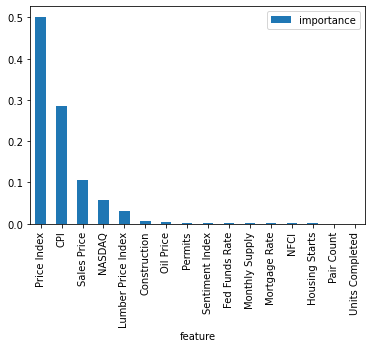

In [49]:
# add the feature importance to a dataframe
feature_importance_df = pd.DataFrame({"feature": feature_list, "importance": importances})
# sort the dataframe by the importance
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# set the index to be the feature
feature_importance_df = feature_importance_df.set_index("feature", drop=True)
# plot the feature importance
feature_importance_df.plot(kind="bar")
plt.show()

In [50]:
# use plotly to create a bar chart of the feature importance
fig = px.bar(feature_importance_df, x=feature_importance_df.index, y="importance", title="Feature Importance", color="importance", color_continuous_scale=px.colors.sequential.Cividis_r)
# save the plot as a png file
fig.write_image("images/feature_importance_custom_6_month_prediction.png")
# show the plot
fig.show()

In [51]:
# define a function to output images of tables
def save_df_as_image(df, filename):
    source = ColumnDataSource(df)
    columns = [TableColumn(field=Ci, title=Ci) for Ci in df.columns]  # bokeh columns
    # add index column
    columns.insert(0, TableColumn(field="index", title="index"))
    # use df index as index column
    source.add(df.index, "index")
    data_table = DataTable(columns=columns, source=source, width=800, height=280)
    export_png(data_table, filename=filename)

In [52]:
# save a table of the feature importance
save_df_as_image(feature_importance_df, "images/feature_importance_custom_6_month_prediction_table.png")